# Microstructure characterization of battery materials based on voxelated image data: Computation of active surface area and tortuosity

## Battery microstructures

The study is complemented by three realistic microstructures, namely a
representative volume element of nano-porous NVP-C [Neumann et. al. 2024](https://chemistry-europe.onlinelibrary.wiley.com/doi/10.1002/batt.202300409) which is a promising cathode
material for sodium ion batteries, a section from a commercial NMC
electrode from x-ray tomography [Usseglio-Viretta et. al. 2018](https://iopscience.iop.org/article/10.1149/2.0731814jes/pdf) and a biphasic iron-graphite structure from [microlib](https://microlib.io) to underline the generality of the used methods.
<br>


<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/battery-structures/nanoporous-NVP.png" alt="Image 1" width="300" />
</p>
<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/battery-structures/xray-electrode-CBD.png" alt="Image 1" width="300" />
</p>
<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/battery-structures/graphite-ferrite.png" alt="Image 1" width="300" />
</p>


**Author**: Simon Daubner<br>
**Department**: Department of Mechanical Engineering<br>
**Institution**: Karlsruhe Institute of Technology

In [1]:
import numpy as np
import tifffile

import metrics
import data
import time

### Full electrode example: NMC commercial electrode

In [2]:
path_to_tif = "data-paper/battery-structures/nmc-1-cal-withcbd-w099-binarized.tif"
tif_file = tifffile.imread(path_to_tif)
structure = np.array(tif_file)
structure = structure[20:-20,20:-20,20:-20]
print("Stack shape:", structure.shape)

labels = {"pore":0, "NMC":1, "CBD":2}
px = 398e-9 # pixel resolution in m

Stack shape: (213, 213, 213)


### NVP-C: nanoporous cathode material for sodium ion batteries

In [3]:
# path_to_images = "../VirtualStructures/Model_NVP_60/Model_NVP_60_VolC_150_N=01"
# path_to_images = "../VirtualStructures/Model_NVP_60/Model_NVP_60_VolC_275_N=01"
# path_to_images = "../VirtualStructures/Model_NVP_60/Model_NVP_60_VolC_300_N=01"
# structure = data.read_image_stack_pgm(path_to_images)
# print("Stack shape:", structure.shape)

# NVP = 255, carbon = 0, pore = 155
# labels = {"NVP":255, "carbon":0, "pore":155}
# px = 16.6e-9 # pixel resolution in m

### Biphasic iron-graphite structure from [microlib](https://microlib.io)

**Description:** The addition of a substantial amount of silicon to a relatively low carbon cast iron serves to induce the cementite to transform to ferrite and graphite flakes. This results in the properties of the resultant metal being more similar to that of grey cast iron, i.e. making it easier to machine and improving wear resistance.<br>
**Contributor:** Dr R F Cochrane<br>
**Organisation:** Department of Materials, University of Leeds<br>
**Voxel size:** 1.375 µm

In [4]:
#path_to_tif = "/.../microstructure378.tif"
#tif_file = tifffile.imread(path_to_tif)
#structure = np.array(tif_file)
#print("Stack shape:", structure.shape)

#labels = {"ferrite":1, "graphite":0}
#px = 1.375e-6 # pixel resolution in m

### Generic script for microstructure metrics

Load one of the three samples above or try your own data. The following code snippets will extract the

- volume fraction,
- surface area,
- pairwise-surface area,
- through-feature connectivities and
- tortuosity factors

of all phases defined by the `labels` dictionary.

#### Volume fractions

In [8]:
volume_fraction = {}

for key, value in labels.items():
    # Compute volume fraction of full datset
    volume_fraction[key] = metrics.volume_fraction(structure , value)
    print(f"Volume fraction of {key}: {volume_fraction[key]:.4f}")

Volume fraction of pore: 0.3598
Volume fraction of NMC: 0.5062
Volume fraction of CBD: 0.1340


#### Surface areas

In [9]:
surface = {}
for key, value in labels.items():
    timer = []
    timer.append(time.time())
    smooth_field = metrics.smooth_with_convolution((structure == value).astype(float))
    area_marching = metrics.specific_surface_area_marching(smooth_field, voxel_size=px)
    timer.append(time.time())
    surface[key] = metrics.specific_surface_area((structure == value).astype(float), dx=px, dy=px, dz=px, smooth=1)
    timer.append(time.time())
    print(f"Specific surface area of {key}: {surface[key]*1e-6:.5f} [1/µm]")
    print(f"Rel. difference marching vs. gradient: eps_a={(area_marching-surface[key])/surface[key]}, t={timer[2]-timer[1]}s vs {timer[1]-timer[0]}")

for key1, value in labels.items():
    for key2, value in labels.items():
        if key1 != key2:
            for key3, value in labels.items():
                if key3 != key2 and key3 != key1:
                    area12 = 0.5*(surface[key1] + surface[key2] - surface[key3])
                    area13 = 0.5*(surface[key1] + surface[key3] - surface[key2])
                    area23 = 0.5*(surface[key2] + surface[key3] - surface[key1])
                    print(f"Specific surface area of {key1}-{key2}:  {area12*1e-6:.5f} [1/µm]")
                    print(f"Specific surface area of {key1}-{key3}:  {area13*1e-6:.5f} [1/µm]")
                    print(f"Specific surface area of {key2}-{key3}:  {area23*1e-6:.5f} [1/µm]")
            break
    break

Specific surface area of pore: 0.30090 [1/µm]
Rel. difference marching vs. gradient: eps_a=0.12437984130393369, t=0.21974825859069824s vs 1.240422248840332
Specific surface area of NMC: 0.24761 [1/µm]
Rel. difference marching vs. gradient: eps_a=-0.002599468506170155, t=0.2213273048400879s vs 0.8931124210357666
Specific surface area of CBD: 0.31347 [1/µm]
Rel. difference marching vs. gradient: eps_a=0.24328094053772345, t=0.22079110145568848s vs 1.4103147983551025
Specific surface area of pore-NMC:  0.11752 [1/µm]
Specific surface area of pore-CBD:  0.18338 [1/µm]
Specific surface area of NMC-CBD:  0.13009 [1/µm]


#### Through feature connectivity

In [10]:
through_fraction = {}
for key, value in labels.items():
    through_fraction[key] = {}
    _, through_fraction[key]['x'] = metrics.extract_through_feature(structure, value, 'x')
    _, through_fraction[key]['y'] = metrics.extract_through_feature(structure, value, 'y')
    _, through_fraction[key]['z'] = metrics.extract_through_feature(structure, value, 'z')

print( "With |  side  |  edge  | corner | connectivity")
for key, value in labels.items():
    print(f" x = | {through_fraction[key]['x'][0]:.4f} | {through_fraction[key]['x'][1]:.4f} | {through_fraction[key]['x'][2]:.4f} | % of {key} are connected")
    print(f" y = | {through_fraction[key]['y'][0]:.4f} | {through_fraction[key]['y'][1]:.4f} | {through_fraction[key]['y'][2]:.4f} | % of {key} are connected")
    print(f" z = | {through_fraction[key]['z'][0]:.4f} | {through_fraction[key]['z'][1]:.4f} | {through_fraction[key]['z'][2]:.4f} | % of {key} are connected")

With |  side  |  edge  | corner | connectivity
 x = | 0.9898 | 0.9978 | 0.9987 | % of pore are connected
 y = | 0.9898 | 0.9978 | 0.9987 | % of pore are connected
 z = | 0.9898 | 0.9978 | 0.9987 | % of pore are connected
 x = | 0.9974 | 0.9985 | 0.9985 | % of NMC are connected
 y = | 0.9974 | 0.9985 | 0.9985 | % of NMC are connected
 z = | 0.9974 | 0.9985 | 0.9985 | % of NMC are connected
 x = | 0.9772 | 0.9940 | 0.9963 | % of CBD are connected
 y = | 0.9772 | 0.9940 | 0.9963 | % of CBD are connected
 z = | 0.9772 | 0.9940 | 0.9963 | % of CBD are connected


#### Tortuosity factors

In [11]:
tau = {}
# for key, value in labels.items():
    # tau_vgl = metrics.tortuosity(structure == value, run_on='cuda')
    # through_feature, through_fraction = metrics.extract_through_feature(structure, value, 'x', connectivity=1)
    # tau[key] = metrics.tortuosity(through_feature[0], run_on='cuda')
    # print(f"Tortuosity factor of {key} in x: {tau[key]/through_fraction[0]:.5f} ({tau_vgl:.5f}).")
    # tau_vgl = metrics.tortuosity(np.transpose(structure == value, (1,0,2)), run_on='cuda')
    # through_feature, through_fraction = metrics.extract_through_feature(structure, value, 'y', connectivity=1)
    # tau[key] = metrics.tortuosity(np.transpose(through_feature[0], (1,0,2)), run_on='cuda')
    # print(f"Tortuosity factor of {key} in y: {tau[key]/through_fraction[0]:.5f} ({tau_vgl:.5f}).")
    # tau_vgl = metrics.tortuosity(np.transpose(structure == value, (2,0,1)), run_on='cuda')
    # through_feature, through_fraction = metrics.extract_through_feature(structure, value, 'z', connectivity=1)
    # tau[key] = metrics.tortuosity(np.transpose(through_feature[0], (2,0,1)), run_on='cuda')
    # print(f"Tortuosity factor of {key} in z: {tau[key]/through_fraction[0]:.5f} ({tau_vgl:.5f}).")

### Feature resolution

A segementation of each phases into its features (e.g. spherical particles) is performed using the [SNOW segmentation](https://porespy.org/modules/generated/generated/porespy.filters.snow_partitioning.html) combined with subsequent analysis to quantify the uncertainty of the extracted metrics. All features that are touching the domain boundaries are excluded to remove artefacts.

Note that the SNOW segmentation employs a spherical structuring element with radius r (in pixels) to avoid over-segmentation. For phases which are not well-resolved on the voxel grid (e.g. the CBD in the first example), this results in drastic changes of the resulting segmentation.

In [12]:
import porespy as ps

radii_r2 = {}
surf_marching_r2 = {}
surf_gradient_r2 = {}
radii_r4 = {}
surf_marching_r4 = {}
surf_gradient_r4 = {}
box_volume = np.prod(structure.shape)

for key, value in labels.items():
    snow_labels = (ps.filters.snow_partitioning(structure == value, r_max=2)).regions
    data.extract_inner_features(snow_labels)
    # Re-label to ensure consecutive order of integers
    snow_relabelled = data.relabel_random_order(snow_labels)

    snow_volumes=ps.metrics.region_volumes(snow_relabelled, mode='voxel')
    # Compute equivalent pixel radius assuming spherical feature shape
    radii_r2[key] = (3/4*snow_volumes/np.pi)**(1/3)

    timer = []
    timer.append(time.time())
    surf_marching_r2[key] = ps.metrics.region_surface_areas(snow_relabelled)/box_volume
    timer.append(time.time())
    surf_gradient_r2[key] = metrics.specific_surface_areas_torch(snow_relabelled, device='cuda')
    timer.append(time.time())
    print(f"Porespy computation took: {timer[1]-timer[0]}s")
    print(f"Gradient method took: {timer[2]-timer[1]}s")

for key, value in labels.items():
    snow_labels = (ps.filters.snow_partitioning(structure == value)).regions
    data.extract_inner_features(snow_labels)
    # Re-label to ensure consecutive order of integers
    snow_relabelled = data.relabel_random_order(snow_labels)

    snow_volumes=ps.metrics.region_volumes(snow_relabelled, mode='voxel')
    # Compute equivalent pixel radius assuming spherical feature shape
    radii_r4[key] = (3/4*snow_volumes/np.pi)**(1/3)

    timer = []
    timer.append(time.time())
    surf_marching_r4[key] = ps.metrics.region_surface_areas(snow_relabelled)/box_volume
    timer.append(time.time())
    surf_gradient_r4[key] = metrics.specific_surface_areas_torch(snow_relabelled, device='cuda')
    timer.append(time.time())
    print(f"Porespy computation took: {timer[1]-timer[0]}s")
    print(f"Gradient method took: {timer[2]-timer[1]}s")

0it [00:00, ?it/s]

3308 of initial 4406 labels remaining.


Computing region volumes                                    :   0%|          | 0/3307 [00:00<?, ?it/s]

Computing region surface area                               :   0%|          | 0/3307 [00:00<?, ?it/s]

Porespy computation took: 31.5401873588562s
Gradient method took: 4.1539270877838135s


0it [00:00, ?it/s]

581 of initial 1010 labels remaining.


Computing region volumes                                    :   0%|          | 0/580 [00:00<?, ?it/s]

Computing region surface area                               :   0%|          | 0/580 [00:00<?, ?it/s]

Porespy computation took: 6.099140405654907s
Gradient method took: 0.8324720859527588s


0it [00:00, ?it/s]

172 of initial 483 labels remaining.


Computing region volumes                                    :   0%|          | 0/171 [00:00<?, ?it/s]

Computing region surface area                               :   0%|          | 0/171 [00:00<?, ?it/s]

Porespy computation took: 2.430401563644409s
Gradient method took: 0.37559080123901367s


0it [00:00, ?it/s]

1294 of initial 1959 labels remaining.


Computing region volumes                                    :   0%|          | 0/1293 [00:00<?, ?it/s]

Computing region surface area                               :   0%|          | 0/1293 [00:00<?, ?it/s]

Porespy computation took: 13.00886869430542s
Gradient method took: 1.3579316139221191s


0it [00:00, ?it/s]

471 of initial 851 labels remaining.


Computing region volumes                                    :   0%|          | 0/470 [00:00<?, ?it/s]

Computing region surface area                               :   0%|          | 0/470 [00:00<?, ?it/s]

Porespy computation took: 5.0857226848602295s
Gradient method took: 0.5277190208435059s


0it [00:00, ?it/s]

4 of initial 50 labels remaining.


Computing region volumes                                    :   0%|          | 0/3 [00:00<?, ?it/s]

Computing region surface area                               :   0%|          | 0/3 [00:00<?, ?it/s]

Porespy computation took: 0.15245485305786133s
Gradient method took: 0.1551511287689209s


#### Plot histogram of feature radii

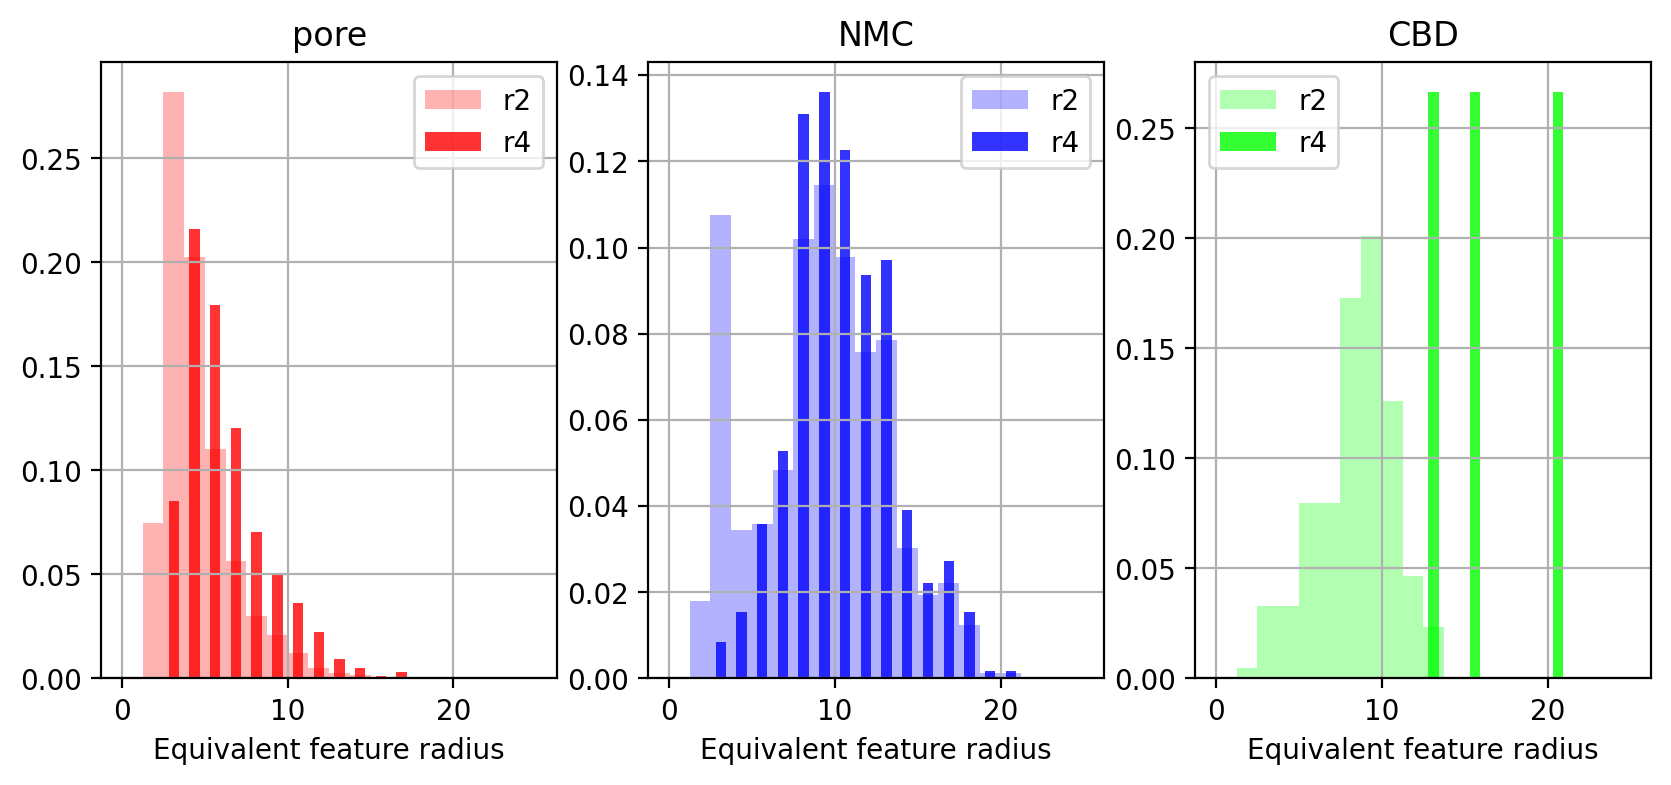

In [13]:
import matplotlib.pyplot as plt
colors = ['red', 'blue', 'lime']

fig, ((ax0, ax1, ax2)) = plt.subplots(nrows=1, ncols=3, figsize=(10, 4), dpi=200)
axes = [ax0, ax1, ax2]
i = 0
for key, value in labels.items():
    axes[i].hist(radii_r2[key], bins=20, density=True, range=(0,25), alpha=0.3, label='r2', color=colors[i])
    axes[i].hist(radii_r4[key], bins=20, rwidth=0.5, density=True, range=(0,25), alpha=0.8, label='r4', color=colors[i])
    axes[i].set_title(key)
    axes[i].set_xlabel('Equivalent feature radius')
    axes[i].legend()
    axes[i].grid()
    i = i + 1

plt.show()

In [ ]:
for key, value in labels.items():
    name = 'volumes_hist_'+key+'.txt'
    data.export_histogram(radii_r4[key], bins=20, density=True, range=(0,25), filename=name)

#### Plot histogram of surface areas

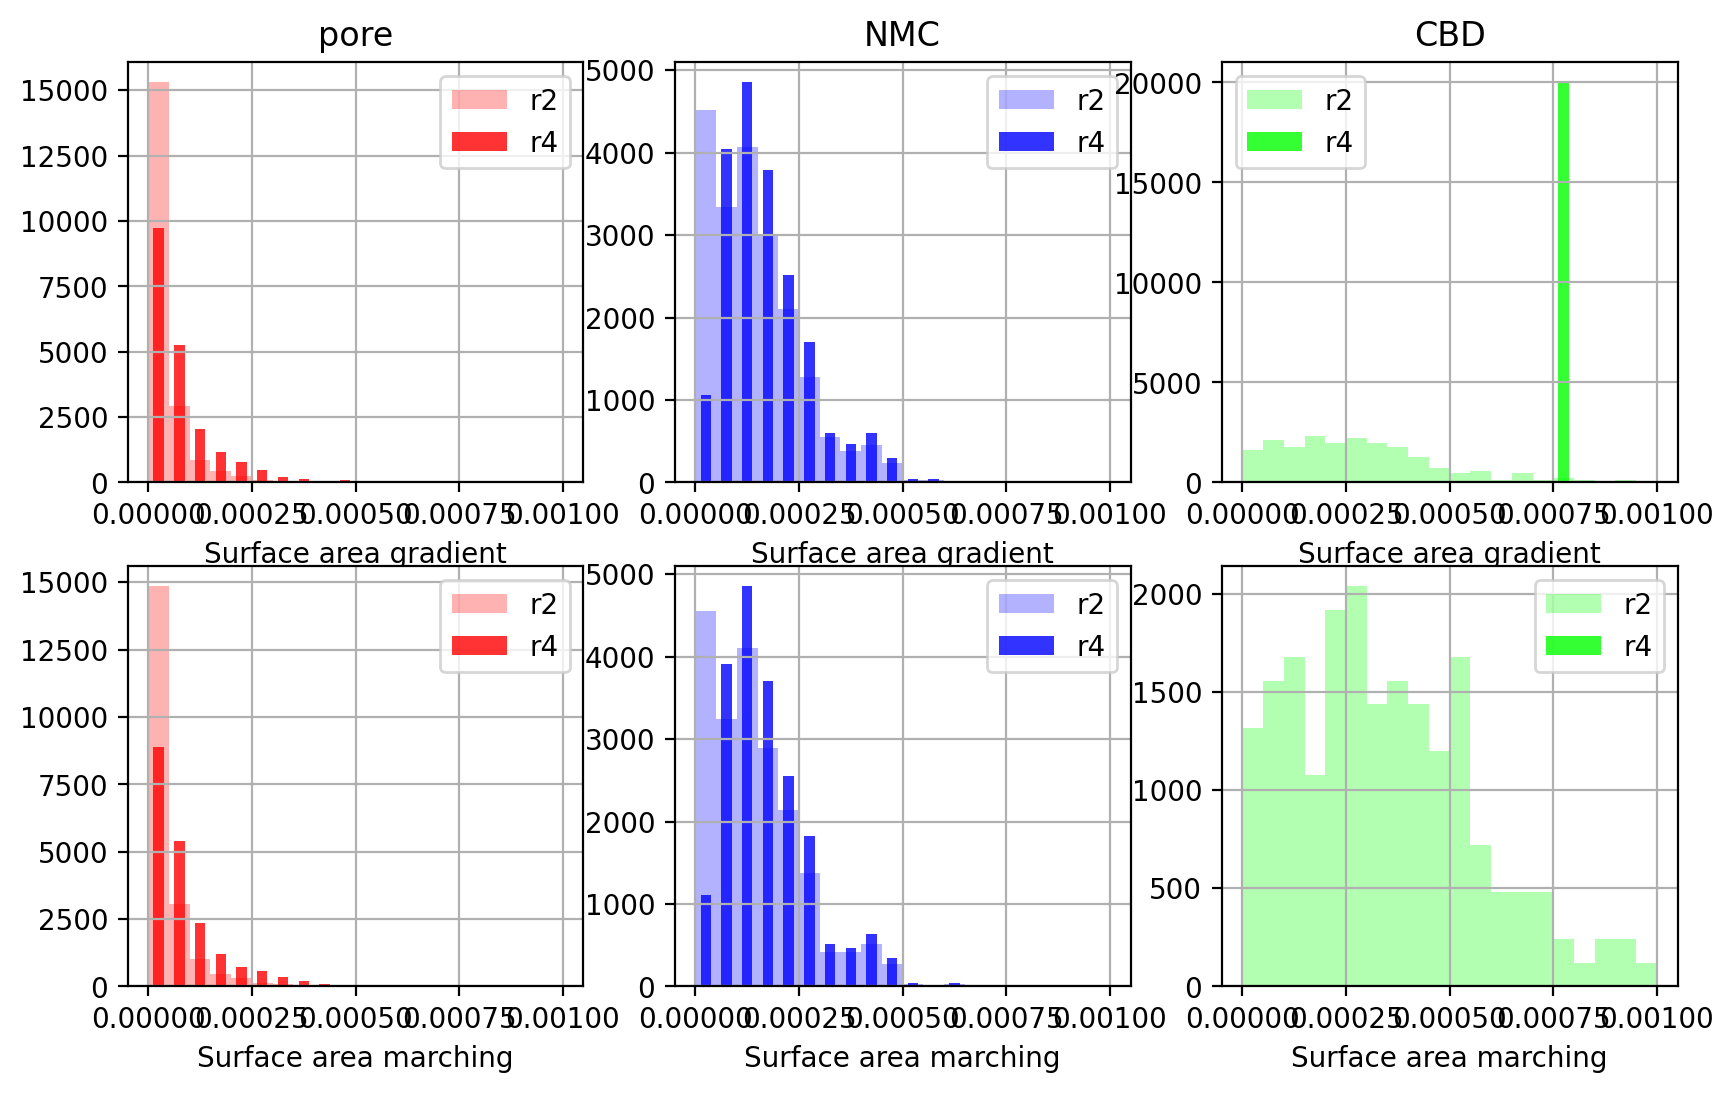

In [14]:
colors = ['red', 'blue', 'lime', 'red', 'blue', 'lime']

fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(10, 6), dpi=200)
axes = [ax0, ax1, ax2, ax3, ax4, ax5]
range = 1e-3
i = 0
for key, value in labels.items():
    axes[i].hist(surf_gradient_r2[key], bins=20, density=True, range=(0,range), alpha=0.3, label='r2', color=colors[i])
    axes[i].hist(surf_gradient_r4[key], bins=20, rwidth=0.5, density=True, range=(0,range), alpha=0.8, label='r4', color=colors[i])
    axes[i].set_title(key)
    axes[i].set_xlabel('Surface area gradient')
    axes[i].legend()
    axes[i].grid()
    i = i + 1

for key, value in labels.items():
    axes[i].hist(surf_marching_r2[key], bins=20, density=True, range=(0,range), alpha=0.3, label='r2', color=colors[i])
    axes[i].hist(surf_marching_r4[key], bins=20, rwidth=0.5, density=True, range=(0,range), alpha=0.8, label='r4', color=colors[i])
    axes[i].set_xlabel('Surface area marching')
    axes[i].legend()
    axes[i].grid()
    i = i + 1

plt.show()

#### Histogram of sphericity

Mean sphericity of pore:0.8905113941174673
Mean sphericity of pore:0.8012783603278368
Mean sphericity of NMC:0.9061127746157385
Mean sphericity of NMC:0.911842289123356
Mean sphericity of CBD:0.43779901949023664
Mean sphericity of CBD:0.2206100100255015
Mean sphericity of pore:0.8774156689631697
Mean sphericity of pore:0.740582594419341
Mean sphericity of NMC:0.8868408445470407
Mean sphericity of NMC:0.900850298877323
Mean sphericity of CBD:0.3517373821493046
Mean sphericity of CBD:0.16473194416957126


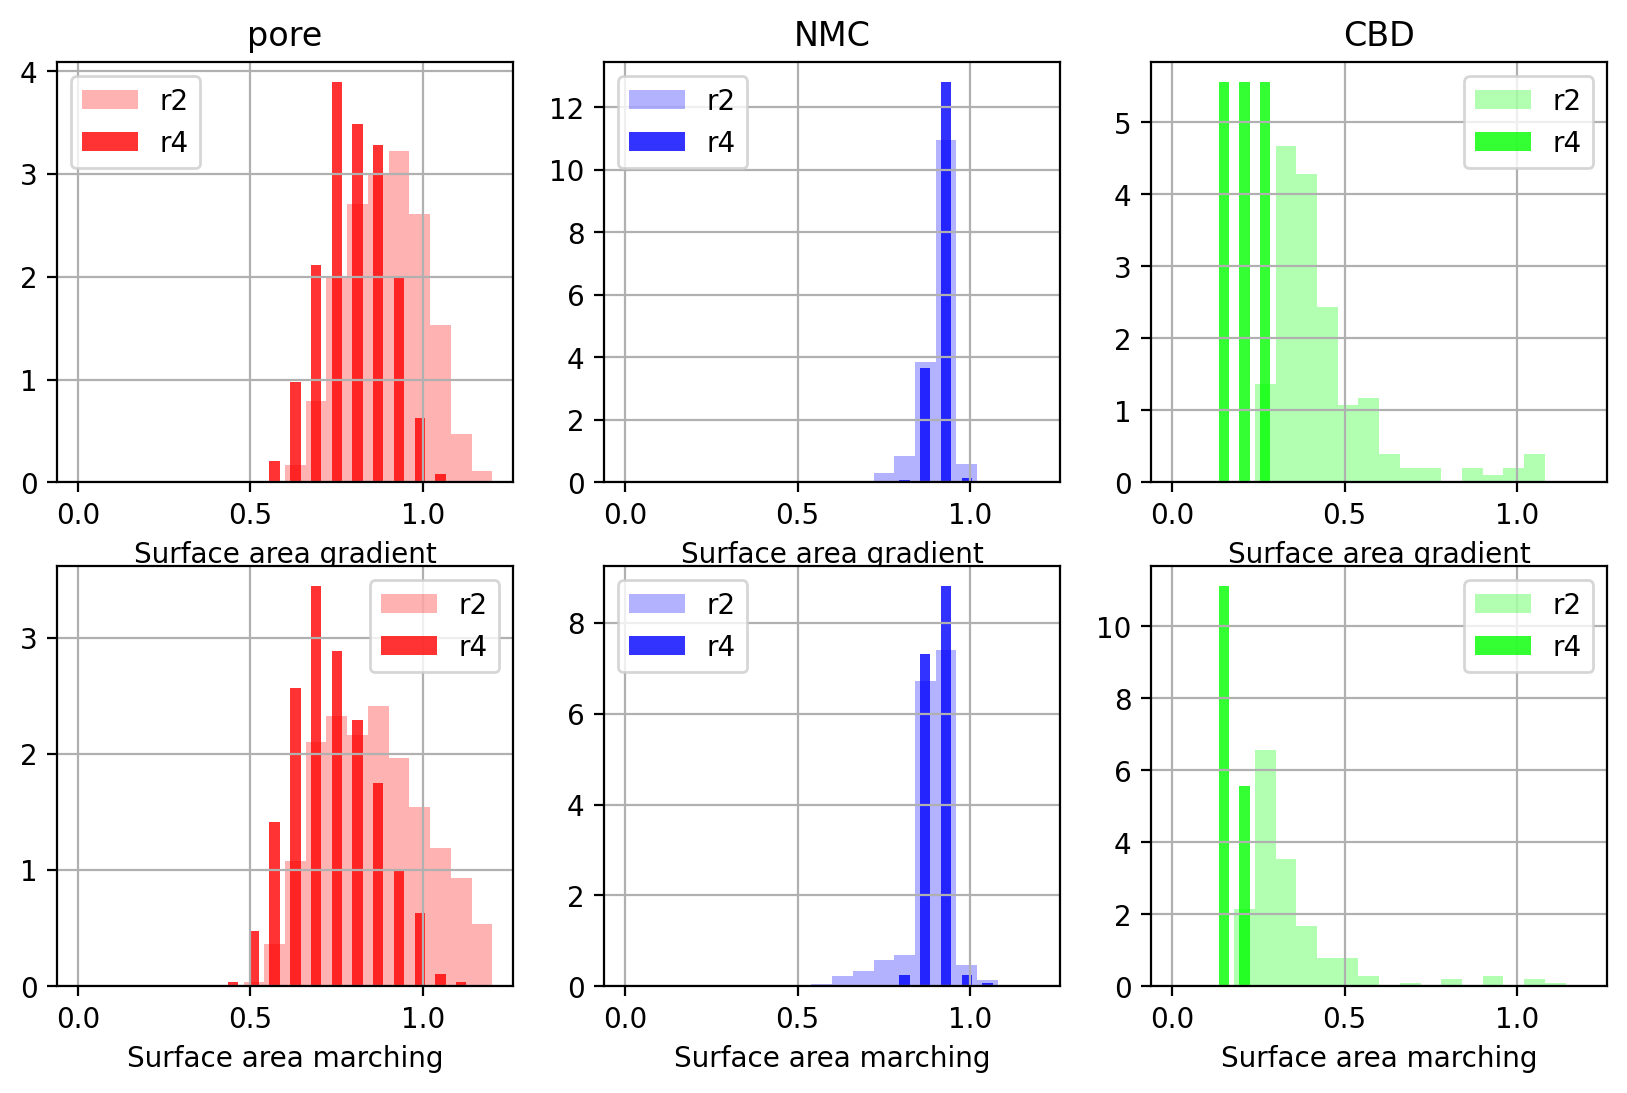

In [15]:
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(10, 6), dpi=200)
axes = [ax0, ax1, ax2, ax3, ax4, ax5]
range = 1.2
i = 0
for key, value in labels.items():
    axes[i].hist((4*np.pi*radii_r2[key]**2)/(surf_gradient_r2[key]*box_volume), bins=20, density=True, range=(0,range), alpha=0.3, label='r2', color=colors[i])
    axes[i].hist((4*np.pi*radii_r4[key]**2)/(surf_gradient_r4[key]*box_volume), bins=20, rwidth=0.5, density=True, range=(0,range), alpha=0.8, label='r4', color=colors[i])
    axes[i].set_title(key)
    axes[i].set_xlabel('Surface area gradient')
    axes[i].legend()
    axes[i].grid()
    print('Mean sphericity of '+key+f':{np.mean((4*np.pi*radii_r2[key]**2)/(surf_gradient_r2[key]*box_volume))}')
    print('Mean sphericity of '+key+f':{np.mean((4*np.pi*radii_r4[key]**2)/(surf_gradient_r4[key]*box_volume))}')
    i = i + 1

for key, value in labels.items():
    axes[i].hist((4*np.pi*radii_r2[key]**2)/(surf_marching_r2[key]*box_volume), bins=20, density=True, range=(0,range), alpha=0.3, label='r2', color=colors[i])
    axes[i].hist((4*np.pi*radii_r4[key]**2)/(surf_marching_r4[key]*box_volume), bins=20, rwidth=0.5, density=True, range=(0,range), alpha=0.8, label='r4', color=colors[i])
    axes[i].set_xlabel('Surface area marching')
    axes[i].legend()
    axes[i].grid()
    print('Mean sphericity of '+key+f':{np.mean((4*np.pi*radii_r2[key]**2)/(surf_marching_r2[key]*box_volume))}')
    print('Mean sphericity of '+key+f':{np.mean((4*np.pi*radii_r4[key]**2)/(surf_marching_r4[key]*box_volume))}')
    i = i + 1

plt.show()